# Application 5 - Handwritten Digits CNN

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
# Specify the Mean and standard deviation
mean_gray   = 0.1307
stddev_gray = 0.3081

# transform images to tensors and normalize a tensor image with mean and standard deviation
transforms_ori = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((mean_gray,), (stddev_gray,))])

# resize andtransform images to tensors and normalize a tensor image with mean and standard deviation
transforms_photo = transforms.Compose([transforms.Resize((28,28)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((mean_gray,), (stddev_gray,))])

# load training dataset
train_dataset = datasets.MNIST(root = './data', 
                            train = True, 
                            transform = transforms_ori,
                            download = True)
# load testing dataset
test_dataset = datasets.MNIST(root = './data', 
                            train = False, 
                            transform = transforms_ori)

4


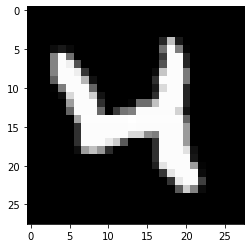

In [3]:
#  visualize single image in train dataset
print(train_dataset[20][1])
random_image = train_dataset[20][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_image.reshape(28, 28), cmap = 'gray')

In [4]:
batch_size = 100
epochs     = 10

In [5]:
# make the dataset iterable
train_load = torch.utils.data.DataLoader(dataset    = train_dataset,
                                         batch_size = batch_size,
                                         shuffle    = True)

test_load = torch.utils.data.DataLoader(dataset    = test_dataset,
                                         batch_size = batch_size,
                                         shuffle    = False)

In [6]:
print('There are {} images in the training set'.format(len(train_dataset)))
print('There are {} images in the test set'.format(len(test_dataset)))
print('There are {} images in the train loader'.format(len(train_load)))
print('There are {} images in the test loader'.format(len(test_load)))

There are 60000 images in the training set
There are 10000 images in the test set
There are 600 images in the train loader
There are 100 images in the test loader


In [7]:
#Create the model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        # Convo Layer 1
        self.cnn1       = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3,stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(8)                                         # apply batch normalization
        self.relu       = nn.ReLU()                                                 # apply relu function
        self.maxpool1   = nn.MaxPool2d(kernel_size=2)                               # apply Max Pool
        
        # Convo Layer 2
        self.cnn2       = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(32)                                        # apply batch normalization
        self.maxpool2   = nn.MaxPool2d(kernel_size=2)                               # apply Max Pool

        # flatten the feature map and apply dropout technic
        self.fc1        = nn.Linear(in_features=1568, out_features=600)
        self.droput     = nn.Dropout(p=0.5)
        self.fc2        = nn.Linear(in_features=600, out_features=10)

    # define feed forward network
    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)

        # now we have to flatten the output. This is where we apply the feed forward neural network as learned before
        out = out.view(-1,1568)
        
        # forward through fully connected layer 
        out = self.fc1(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc2(out)
        return out

In [8]:
# create model object
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()  

loss_fn = nn.CrossEntropyLoss()                                                     # define loss function
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.01)                 # define SGD optimizer

In [9]:
# visualize what's happening
iterations = 0
correct   = 0
for i, (inputs, labels) in enumerate (train_load):
    if CUDA:
        inputs = inputs.cuda()
        labels = labels.cuda()

    print("For one iteration, this is what happens...")
    print("Input Shape: ", inputs.shape)
    print("Label Shape: ", labels.shape)

    outputs = model(inputs)
    print("Output Shape: ", outputs.shape)
    _, predicted = torch.max(outputs, 1)
    print("Predicted Shape: ", predicted.shape)
    print("Predicted Tensor: ")
    print(predicted)
    correct += (predicted == labels).sum()
    print("Correct Prediction: ", correct)
    break

For one iteration, this is what happens...
Input Shape:  torch.Size([100, 1, 28, 28])
Label Shape:  torch.Size([100])
Output Shape:  torch.Size([100, 10])
Predicted Shape:  torch.Size([100])
Predicted Tensor: 
tensor([6, 4, 4, 5, 4, 3, 0, 5, 4, 0, 9, 9, 5, 1, 4, 4, 1, 0, 0, 8, 5, 9, 4, 4,
        3, 9, 9, 0, 6, 0, 4, 4, 4, 5, 4, 6, 6, 4, 6, 9, 6, 3, 6, 4, 1, 4, 0, 4,
        4, 6, 1, 4, 4, 0, 4, 0, 0, 4, 4, 6, 6, 3, 5, 4, 6, 0, 6, 4, 1, 4, 6, 6,
        5, 4, 5, 9, 3, 9, 1, 4, 4, 6, 6, 0, 0, 9, 9, 4, 5, 0, 0, 6, 4, 6, 4, 0,
        5, 4, 1, 0])
Correct Prediction:  tensor(14)


In [10]:
# training the CNN
num_epoch = 10

#Define the lists to store the results of loss and accuracy
train_loss     = []
test_loss      = []
train_accuracy = []
test_accuracy  = []

for epoch in range(num_epoch):
    correct    = 0
    iterations = 0
    iter_loss  = 0.0

    # put the network into training mode
    model.train()

    for i, (inputs, labels) in enumerate (train_load):
        inputs = Variable(inputs)
        labels = Variable(labels)

        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        model.zero_grad()                                               # clear the gradient
        outputs = model(inputs)                                         # pass input through feed forward function
        loss = loss_fn(outputs, labels)                                 # calculate the loss
        iter_loss += loss.item()                                        # update loss for single iteration
        loss.backward()                                                 # backpropagation
        optimizer.step()                                                # update the weights

        # record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        iterations += 1

    train_loss.append(iter_loss/iterations)                             # record the training loss
    train_accuracy.append(100*correct/len(train_dataset))               # record the training accuracy

    # testing phase
    test_iter_loss = 0.0
    correct = 0
    iterations = 0

    # put the network into evaluation mode
    model.eval()

    for i, (inputs, labels) in enumerate(test_load):

        # convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)

        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)                                         # pass input through feed forward function
        loss = loss_fn(outputs, labels)                                 # calculate the loss
        test_iter_loss += loss.item()                                             # update the loss for single iteration

        # record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        iterations += 1

    test_loss.append(test_iter_loss/iterations)
    test_accuracy.append(100*correct/len(test_dataset))

    print("Epoch: [{}]/[{}], Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Accuracy: {:.3f}"
          .format(epoch+1, num_epoch, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]))

Epoch: [1]/[10], Training Loss: 0.505, Training Accuracy: 86.032, Testing Loss: 0.160, Testing Accuracy: 95.700
Epoch: [2]/[10], Training Loss: 0.166, Training Accuracy: 95.330, Testing Loss: 0.100, Testing Accuracy: 97.130
Epoch: [3]/[10], Training Loss: 0.118, Training Accuracy: 96.617, Testing Loss: 0.079, Testing Accuracy: 97.650
Epoch: [4]/[10], Training Loss: 0.096, Training Accuracy: 97.168, Testing Loss: 0.064, Testing Accuracy: 98.090
Epoch: [5]/[10], Training Loss: 0.082, Training Accuracy: 97.600, Testing Loss: 0.057, Testing Accuracy: 98.300
Epoch: [6]/[10], Training Loss: 0.074, Training Accuracy: 97.803, Testing Loss: 0.050, Testing Accuracy: 98.500
Epoch: [7]/[10], Training Loss: 0.065, Training Accuracy: 98.145, Testing Loss: 0.046, Testing Accuracy: 98.600
Epoch: [8]/[10], Training Loss: 0.060, Training Accuracy: 98.192, Testing Loss: 0.043, Testing Accuracy: 98.660
Epoch: [9]/[10], Training Loss: 0.056, Training Accuracy: 98.370, Testing Loss: 0.042, Testing Accuracy:

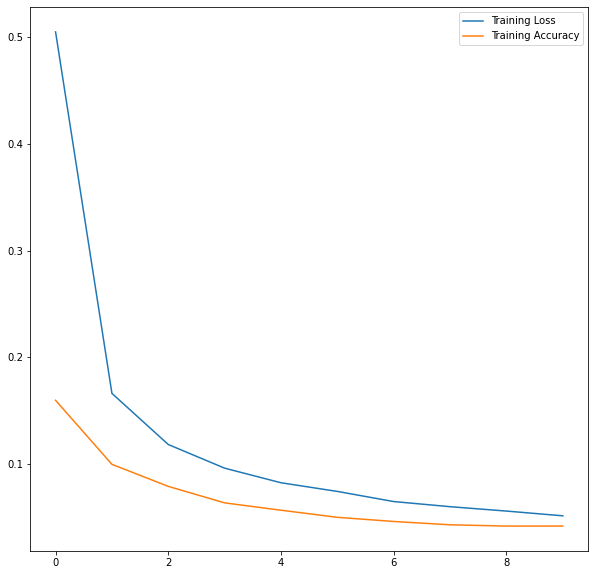

In [11]:
# plotting the loss
f = plt.figure(figsize = (10, 10))
plt.plot(train_loss, label = "Training Loss")
plt.plot(test_loss, label = "Training Accuracy")
plt.legend()
plt.show()

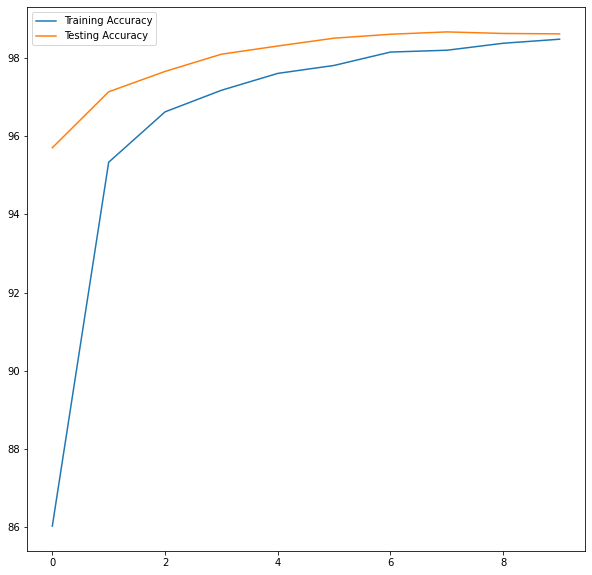

In [12]:
# plotting the accuracy
f = plt.figure(figsize = (10, 10))
plt.plot(train_accuracy, label = "Training Accuracy")
plt.plot(test_accuracy, label = "Testing Accuracy")
plt.legend()
plt.show()

In [13]:
img = test_dataset[20][0].reshape((1, 1, 28, 28))
label = test_dataset[20][1]

model.eval()

if CUDA:
    model = model.cuda()
    img   = img.cuda()

outputs = model(img)
_, predicted = torch.max(outputs, 1)
print("Prediction : {}".format(predicted.item()))
print("Actual     : {}".format(label))

Prediction : 9
Actual     : 9


In [14]:
import cv2
from PIL import Image

# predict function to predict your own image
def predict(img_name, model):
    image = cv2.imread(img_name, 0)                                                 # read the image
    ret, thresholded = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)            # threshold the image
    img = 255 - thresholded                                                         # apply image negative
    cv2.imshow('Original', img)                                                     # display the processed image
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    img = Image.fromarray(img)                                                      # convert the image to array
    img = transforms_photo(img)                                                      # apply the transformation
    img = img.view(1, 1, 28, 28)                                                    # add batch size
    img = Variable(img)                                                             # wrap tensor to variable

    model.eval()

    if CUDA:
        model = model.cuda()
        img   = img.cuda()
    
    outputs = model(img)
    print(outputs)
    print(outputs.data)

    _, predicted = torch.max(outputs, 1)
    return predicted.item()

In [17]:
pred = predict('predict_this_img.jpg', model)
print("Prediction: {}".format(pred))

tensor([[-1.5276,  1.5821,  3.9487,  7.8882, -4.3582, -1.7354, -2.8354, -1.5926,
          2.1380, -3.8122]], grad_fn=<AddmmBackward0>)
tensor([[-1.5276,  1.5821,  3.9487,  7.8882, -4.3582, -1.7354, -2.8354, -1.5926,
          2.1380, -3.8122]])
Prediction: 3
